# TASK IronITA  - Linguistica computazionale II
### Chiara Giurdanella 560686

Dopo aver scelto un Neural Language Model tra quelli visti a lezione, condurre un processo di fine-tuning per 5 epoche. Riportare i seguenti risultati:

*   riportare le curve di loss di training e di validation;
*   per ogni epoca valutare il sistema sul validation set;
*   alla fine dell’ultima epoca, riportare la valutazione del sistema sul test set ufficiale.


In [1]:
!pip install datasets
!pip install evaluate
!pip install scikit-learn
!pip install transformers==4.28.0
!pip install accelerate -U

In [2]:
import os
from google.colab import drive
import numpy as np
import pandas as pd
import datasets
import evaluate
import seaborn as sns
# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
# Librerie per le metriche
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## Caricamento dati

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df= pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset_ironita_2018.csv', delimiter=",")
#  Crea un nuovo DataFrame per i dati di training
train_data = df[df["set"] == "training"]
# Crea un nuovo DataFrame per i dati di test
test_data = df[df["set"] == "test"]

In [5]:
# Seleziono unicamente le feature d'interesse (testi e label)
train_data=train_data[["text","irony"]].reset_index(drop=True)
test_data=test_data[["text","irony"]].reset_index(drop=True)

## Preprocessing dei dati

In [6]:
# Conversione da lista di dizionari a dataset
train = datasets.Dataset.from_pandas(pd.DataFrame(data=train_data))
test = datasets.Dataset.from_pandas(pd.DataFrame(data=test_data))
# Splitting in train e dev del training set
train_dev = train.train_test_split(test_size=0.1)

train = train_dev["train"]
dev = train_dev["test"]
# Stampo 'train' per vedere come è formattato
print(train, "\n")
print("Esempio di testo:", train['text'][0], "\n")
print("Esempio di label:", train['irony'][0], "\n")
# Shape dei dati di train, dev e test
print("Dimensione dei set di training, development e test:")
print("Train:", train.shape)
print("Dev:", dev.shape)
print("Test:", test.shape)

Dataset({
    features: ['text', 'irony'],
    num_rows: 3579
}) 

Esempio di testo: Minori stranieri soli, via libera alla legge che ridisegna l'accoglienza https://t.co/DNyPhCkOzY 

Esempio di label: 0 

Dimensione dei set di training, development e test:
Train: (3579, 2)
Dev: (398, 2)
Test: (872, 2)


## Caricamento del modello
I due modelli impiegati sono i seguenti:

https://huggingface.co/dbmdz/bert-base-italian-cased

https://huggingface.co/osiria/bert-tweet-italian-uncased-sentiment

In [7]:
# Creo una variabile 'model' dove specificherò il modello da utilizzare
model_name_1 = "osiria/bert-tweet-italian-uncased-sentiment"
model_name_2 = 'dbmdz/bert-base-italian-cased'
# Carico il modello
model_1 = AutoModelForSequenceClassification.from_pretrained(model_name_1, num_labels=2)
model_2 = AutoModelForSequenceClassification.from_pretrained(model_name_2, num_labels=2)
# Carico il tokenizzatore
tokenizer_1 = AutoTokenizer.from_pretrained(model_name_1)
tokenizer_2 = AutoTokenizer.from_pretrained(model_name_2)


Some weights of the model checkpoint at dbmdz/bert-base-italian-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model c

##Tokenizzazione tweet

In [8]:
# Funzione che applica la tokenizzazione ai dati di training, dev e test
def tokenize_1(batch):
    tokens = tokenizer_1(batch['text'], padding=True, truncation=True, max_length=512)
    tokens['label'] = batch["irony"]
    return tokens

def tokenize_2(batch):
    tokens = tokenizer_2(batch['text'], padding=True, truncation=True, max_length=512)
    tokens['label'] = batch["irony"]
    return tokens

train_1 = train.map(tokenize_1, batched=True)
dev_1 = dev.map(tokenize_1, batched=True)
test_1 = test.map(tokenize_1, batched=True)

train_2 = train.map(tokenize_2, batched=True)
dev_2 = dev.map(tokenize_2, batched=True)
test_2 = test.map(tokenize_2, batched=True)

train_1.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev_1.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_1.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

train_2.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
dev_2.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_2.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/3579 [00:00<?, ? examples/s]

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/3579 [00:00<?, ? examples/s]

Map:   0%|          | 0/398 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

## Addestramento del modello

In [9]:
#Argomenti per il Trainer
num_epochs = 5
training_args_1 = TrainingArguments(
    f"{model_name_1}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

training_args_2 = TrainingArguments(
    f"{model_name_2}-finetuned",
    evaluation_strategy = "epoch",
    logging_strategy="epoch",
    save_strategy = "epoch",
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

In [10]:
#Prende in input le predictions del modello
def compute_metrics(eval_pred):
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  #applica argmax alle predictions
  predictions = np.argmax(predictions, axis=1)
  #calcola e restituisce l'F-Score fra le predictions e le true labels
  return f1_metric.compute(predictions=predictions, references=labels, average="weighted")

In [11]:
#Definizione del trainer
trainer_1 = Trainer(
    model_1,
    training_args_1,
    train_dataset=train_1,
    eval_dataset=dev_1,
    tokenizer=tokenizer_1,
    compute_metrics=compute_metrics
)
#Training
trainer_1.train()
#specifica dove salvare il modello
trainer_1.save_model("/content/drive/My Drive/FINETUNED_MODEL/tweet_model")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.580100,0.464895,0.758239
2,0.419000,0.464920,0.781422
3,0.270900,0.955819,0.778894
4,0.171700,1.261187,0.777843
5,0.095700,1.308585,0.773915


In [12]:
#Definizione del trainer
trainer_2 = Trainer(
    model_2,
    training_args_2,
    train_dataset=train_2,
    eval_dataset=dev_2,
    tokenizer=tokenizer_2,
    compute_metrics=compute_metrics,
)

# Training
trainer_2.train()
# Specifichiamo dover voler salvare il modello
trainer_2.save_model("/content/drive/My Drive/bert_codes_LC2/FINETUNED_MODEL/basic_model")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.582600,0.483374,0.748125
2,0.418400,0.460827,0.781223
3,0.282300,0.680334,0.804045
4,0.166900,0.883638,0.803985
5,0.100400,0.977706,0.793595


##Evaluation del modello

<ipython-input-13-f937b9c9b399>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)
<ipython-input-13-f937b9c9b399>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Validation"}, ignore_index=True)
<ipython-input-13-f937b9c9b399>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_1 = df_1.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)
<ipython-input-13-f937b9c9b399>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

<Axes: xlabel='Epoch', ylabel='Loss'>

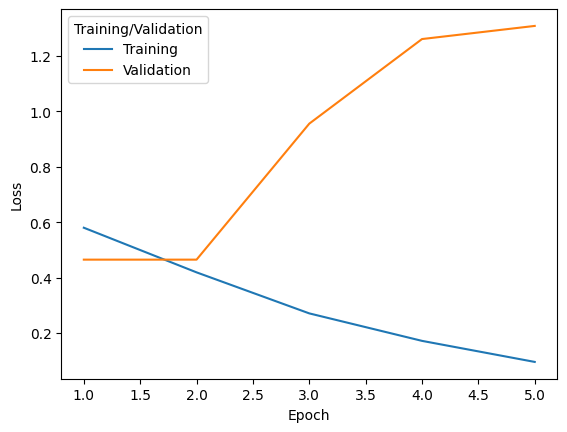

In [13]:
#Monitoraggio della loss sul dataset di training e di evaluation
log_history_1 = trainer_1.state.log_history
#crea dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df_1 = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])
#itera sulla cronologia dei log
for log_data in log_history_1:
  epoch = int(log_data["epoch"])
  #se è presente una chiave "loss" nel log
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    #memorizza la loss di training nel dataframe
    df_1 = df_1.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)
  #se è presente una chiave "eval_loss" nel log
  if "eval_loss" in log_data.keys():
    #memorizza la loss di validation nel dataframe
    loss = log_data["eval_loss"]
    df_1 = df_1.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Validation"}, ignore_index=True)

#Lineplot della loss
sns.lineplot(data=df_1, x="Epoch", y="Loss", hue="Training/Validation")

<ipython-input-14-7f0e064e5b44>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2 = df_2.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)
<ipython-input-14-7f0e064e5b44>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2 = df_2.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Validation"}, ignore_index=True)
<ipython-input-14-7f0e064e5b44>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_2 = df_2.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)
<ipython-input-14-7f0e064e5b44>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

<Axes: xlabel='Epoch', ylabel='Loss'>

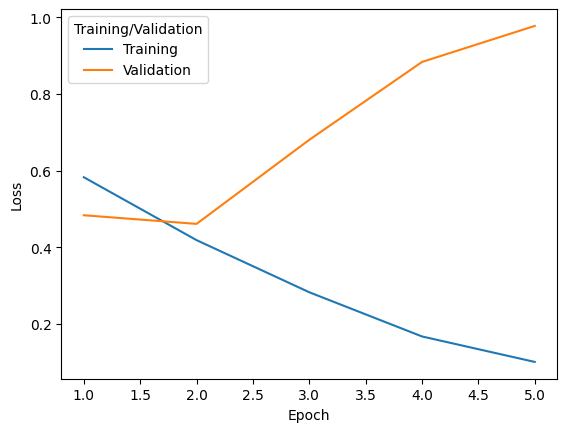

In [14]:
#Monitoraggio della loss sul dataset di training e di evaluation
log_history_2 = trainer_2.state.log_history
#crea dataframe pandas per memorizzare le loss di training/evaluation e poi mostrare graficamente le curve
df_2 = pd.DataFrame(columns=["Epoch", "Loss", "Training/Validation"])
#itera sulla cronologia dei log
for log_data in log_history_2:
  epoch = int(log_data["epoch"])
  #se è presente una chiave "loss" nel log
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    #memorizza la loss di training nel dataframe
    df_2 = df_2.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Training"}, ignore_index=True)
  #se è presente una chiave "eval_loss" nel log
  if "eval_loss" in log_data.keys():
    #memorizza la loss di validation nel dataframe
    loss = log_data["eval_loss"]
    df_2 = df_2.append({"Epoch": epoch, "Loss": loss, "Training/Validation": "Validation"}, ignore_index=True)

#Lineplot della loss
sns.lineplot(data=df_2, x="Epoch", y="Loss", hue="Training/Validation")

##Calcolo performance sul test set

In [15]:
output_predictions_1 = trainer_1.predict(test_1)
output_predictions_2 = trainer_2.predict(test_2)

Classification Report su test set:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       437
           1       0.71      0.73      0.72       435

    accuracy                           0.72       872
   macro avg       0.72      0.72      0.72       872
weighted avg       0.72      0.72      0.72       872
 

Confusion Matrix su test set:


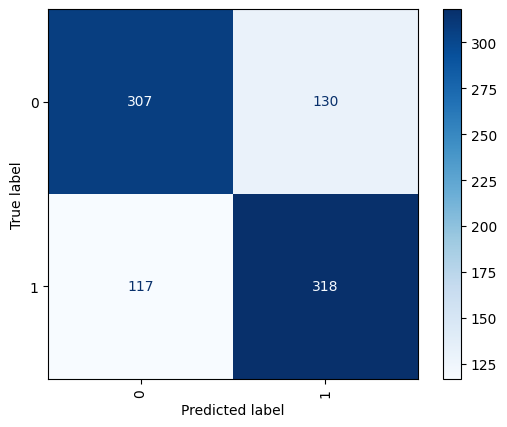

In [16]:
#etichette reali (ground truth) dal test set
y_test_1 = test_1["label"].tolist()
#etichette predette dal modello
y_pred_1 = np.argmax(output_predictions_1.predictions, axis=1)
#calcolo del classification report
report_1 = classification_report(y_test_1, y_pred_1)
#rappresentazione grafica della matrice di confusione
cm_1 = ConfusionMatrixDisplay.from_predictions(y_test_1, y_pred_1, xticks_rotation='vertical', cmap='Blues')

print("Classification Report su test set:")
print(report_1, "\n")
print("Confusion Matrix su test set:")
print(cm_1)

Classification Report su test set:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       437
           1       0.75      0.80      0.78       435

    accuracy                           0.77       872
   macro avg       0.77      0.77      0.77       872
weighted avg       0.77      0.77      0.77       872
 

Confusion Matrix su test set:


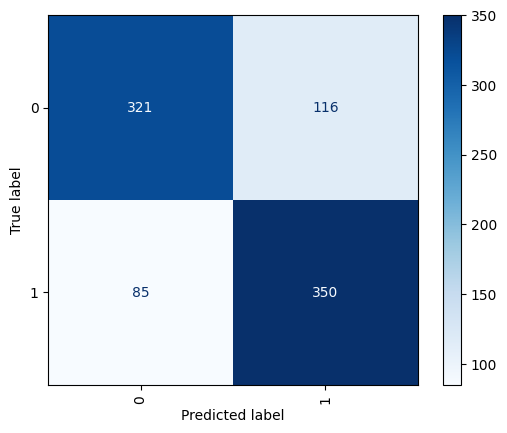

In [17]:
#etichette reali (ground truth) dal test set
y_test_2 = test_2["label"].tolist()
#etichette predette dal modello
y_pred_2 = np.argmax(output_predictions_2.predictions, axis=1)
#calcolo del classification report
report_2 = classification_report(y_test_2, y_pred_2)
#rappresentazione grafica della matrice di confusione
cm_2 = ConfusionMatrixDisplay.from_predictions(y_test_2, y_pred_2, xticks_rotation='vertical', cmap='Blues')

print("Classification Report su test set:")
print(report_2, "\n")
print("Confusion Matrix su test set:")
print(cm_2)